# Image Classification Model - TensorFlow Convolutional Neural Network (Resnet152v2)

## Imports

In [67]:
import tensorflow
import math
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from matplotlib import pyplot as plt

In [68]:
tensorflow.__version__

'2.3.0'

## Settings and Dataset

In [69]:
# Validation ImageDataGenerator with rescaling
valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

# Training ImagaDataGenerator with Augmentation transformation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=15,
                                   brightness_range= [0.5, 1.5],
                                   channel_shift_range=40,
#                                    shear_range=10,
#                                    zoom_range=0.1,
                                   fill_mode='nearest',
#                                    height_shift_range=0.2,
#                                    width_shift_range=0.2
                                  )

# Create a flow from the directory for validation data - seed=42
# Choose subset = 'validation'
valid_gen = valid_datagen.flow_from_directory(directory='train_dataset',
                                              subset='validation',
                                              shuffle=True,
                                              seed=42, # seed to ensure same validation split for both train_gen and valid_gen
                                              target_size=(224,224),
                                              batch_size=64,
#                                               save_to_dir='valid_gen', # for image visualization
                                              class_mode='categorical')

# Create a flow from the directory using same seed and 'training' subset.
train_gen = train_datagen.flow_from_directory(directory='train_dataset',
                                              subset='training',
                                              shuffle=True,
                                              seed=42, # seed to ensure same validation split for train_gen and valid_gen
                                              target_size=(224,224),
                                              batch_size=64,
#                                               save_to_dir='train_gen', # for image visualization
                                              class_mode='categorical')

Found 33 images belonging to 3 classes.
Found 132 images belonging to 3 classes.


In [70]:
# Define checkpoint to save best weights
filepath="weights.ResNet152v2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [71]:
# Define learning rate scheduler
# Time-based learning rate
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

# Step decay learning rate - Drop learning rate by 0.5 for every 10 epochs
def step_decay(epoch):
    initial_lrate = 0.005
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor(epoch/epochs_drop))
    return lrate

# Using step decay
lrate = LearningRateScheduler(step_decay)

# Define callbacks list
callbacks_list = [checkpoint, lrate]

## Model

In [72]:
# Define number of classes and image size
num_classes = 3
image_size = 224

# Instantiate ResNet152v2 base model with imagenet
resnet152v2 = ResNet152V2(weights='imagenet',
            include_top=False,
            pooling='avg',
            input_shape=(image_size, image_size, 3))
resnet152v2.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [73]:
# Create the model
my_model = models.Sequential()

# Add ResNet152v2 base model
my_model.add(resnet152v2)
my_model.add(layers.Dense(num_classes, activation='softmax'))
my_model.layers[0].trainable = False
my_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 6147      
Total params: 58,337,795
Trainable params: 6,147
Non-trainable params: 58,331,648
_________________________________________________________________


In [74]:
rmsprop = RMSprop(learning_rate=0.0,
                  momentum=0.9)

my_model.compile(optimizer=rmsprop,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

## Training

In [57]:
history = my_model.fit(train_gen, epochs=50, validation_data=valid_gen, callbacks=callbacks_list)

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 2.1283 - accuracy: 0.5152
Epoch 00001: val_accuracy improved from -inf to 0.57576, saving model to weights.ResNet152v2.best.hdf5
3/3 [==============================] - 17s 6s/step - loss: 2.1283 - accuracy: 0.5152 - val_loss: 1.8472 - val_accuracy: 0.5758
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 3.0490 - accuracy: 0.4621
Epoch 00002: val_accuracy did not improve from 0.57576
3/3 [==============================] - 16s 5s/step - loss: 3.0490 - accuracy: 0.4621 - val_loss: 3.5484 - val_accuracy: 0.3636
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 2.4125 - accuracy: 0.5606
Epoch 00003: val_accuracy improved from 0.57576 to 0.63636, saving model to weights.ResNet152v2.best.hdf5
3/3 [==============================] - 18s 6s/step - loss: 2.4125 - accuracy: 0.5606 - val_loss: 1.8413 - val_accuracy: 0.6364
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 1.1583 - accu

## Training

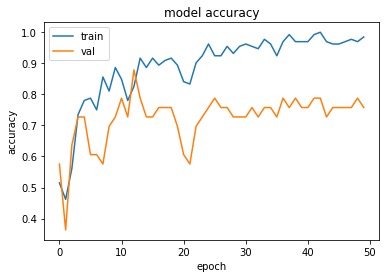

In [58]:
# Plot model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

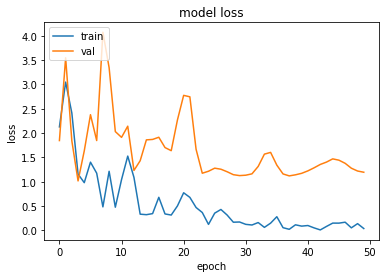

In [59]:
# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

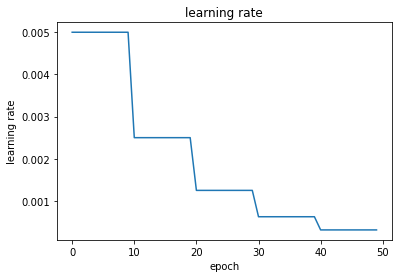

In [60]:
# Plot learning rate
plt.plot(history.history['lr'])
plt.title('learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()

In [76]:
my_model.load_weights('weights.ResNet152v2.best.hdf5')

In [77]:
# Create a flow from the directory for test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(directory='test_dataset',
                                            target_size=(224,224),
                                            batch_size=1,
                                            shuffle=False,
#                                             save_to_dir='test_gen',
                                            class_mode='categorical')

Found 48 images belonging to 3 classes.


In [78]:
# Evaluate model on test set
scores = my_model.evaluate(test_gen)

48/48 [==============================] - 9s 185ms/step - loss: 1.5606 - accuracy: 0.7500


In [79]:
# Predict probabilities
prediction = my_model.predict(test_gen)

In [80]:
# Predict class based on highest probability
y_classes = prediction.argmax(axis=-1)
print(y_classes)

[2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1
 2 0 2 0 0 2 2 2 2 1 1]


In [81]:
# Output labels, Keras generator sorts the labels by alphabetical order
labels = ['dimension', 'grade', 'heat_number']
for i in y_classes:
    predicted_label = sorted(labels)[i]
    print(predicted_label)

heat_number
dimension
grade
dimension
dimension
dimension
dimension
dimension
dimension
dimension
dimension
dimension
dimension
dimension
dimension
dimension
dimension
grade
heat_number
grade
heat_number
grade
grade
grade
grade
grade
grade
grade
grade
grade
grade
grade
heat_number
heat_number
heat_number
grade
grade
heat_number
dimension
heat_number
dimension
dimension
heat_number
heat_number
heat_number
heat_number
grade
grade
